In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# voy a importar Counter para poder contar los elementos que hayan en la lista de generos
from collections import Counter
from itertools import chain

movies = pd.read_parquet("dataset/movies.parquet")
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45454 entries, 0 to 45465
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            45454 non-null  float64
 1   title         45454 non-null  object 
 2   name_genres   45454 non-null  object 
 3   budget        45454 non-null  float64
 4   revenue       45451 non-null  float64
 5   runtime       45194 non-null  float64
 6   popularity    45451 non-null  float64
 7   vote_count    45451 non-null  float64
 8   vote_average  45451 non-null  float64
 9   status        45370 non-null  object 
 10  overview      44500 non-null  object 
 11  release_year  45368 non-null  float64
dtypes: float64(8), object(4)
memory usage: 4.5+ MB


###
###
###


---

In [196]:
movies.describe()

,id,budget,revenue,runtime,popularity,vote_count,vote_average,release_year
count,45454.000000,4.545400e+04,4.545100e+04,45194.000000,45451.000000,45451.000000,45451.000000,45368.000000
mean,108348.389075,4.225399e+06,1.121157e+07,94.133093,2.921765,109.917538,5.618543,1991.879783
std,112445.975875,1.742576e+07,6.433842e+07,38.406223,6.005910,491.356914,1.924085,24.056453
min,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1874.000000
25%,26447.500000,0.000000e+00,0.000000e+00,85.000000,0.385945,3.000000,5.000000,1978.000000
50%,60004.000000,0.000000e+00,0.000000e+00,95.000000,1.127613,10.000000,6.000000,2001.000000
75%,157304.000000,0.000000e+00,0.000000e+00,107.000000,3.679334,34.000000,6.800000,2010.000000
max,469172.000000,3.800000e+08,2.787965e+09,1256.000000,547.488298,14075.000000,10.000000,2020.000000


- *los percentiles 25, 50 y 75 en budget como en revenue aparecen en 0, estos columnas me dan buena info, gracias a estas puedo suponer cosas como:  
.Que si el presupuesto es alto, fue una super produccion, y por lo tanto es una produccion que se espere sea taquillera  
.Si es bajo, es posible que sea una pelicula del estilo cine independiente, por lo que el publico es mas reducido  
.Mientras que si el revenue es bajo hay una alta probabilidad que al publico no les gusto la pelicula  
.Si es alto, es por que fue bien recibida por los espectadores*  

- *los datos de runtime(duracion de la pelicula en minutos) van desde 0 a 1256, por lo que claramente hay datos que estan mal cargados*

- *vote_average parace tener una distribucion adecuada, una vez grafique me voy a sacar la duda de si hay datos fuera de lo normal*

###
###


---

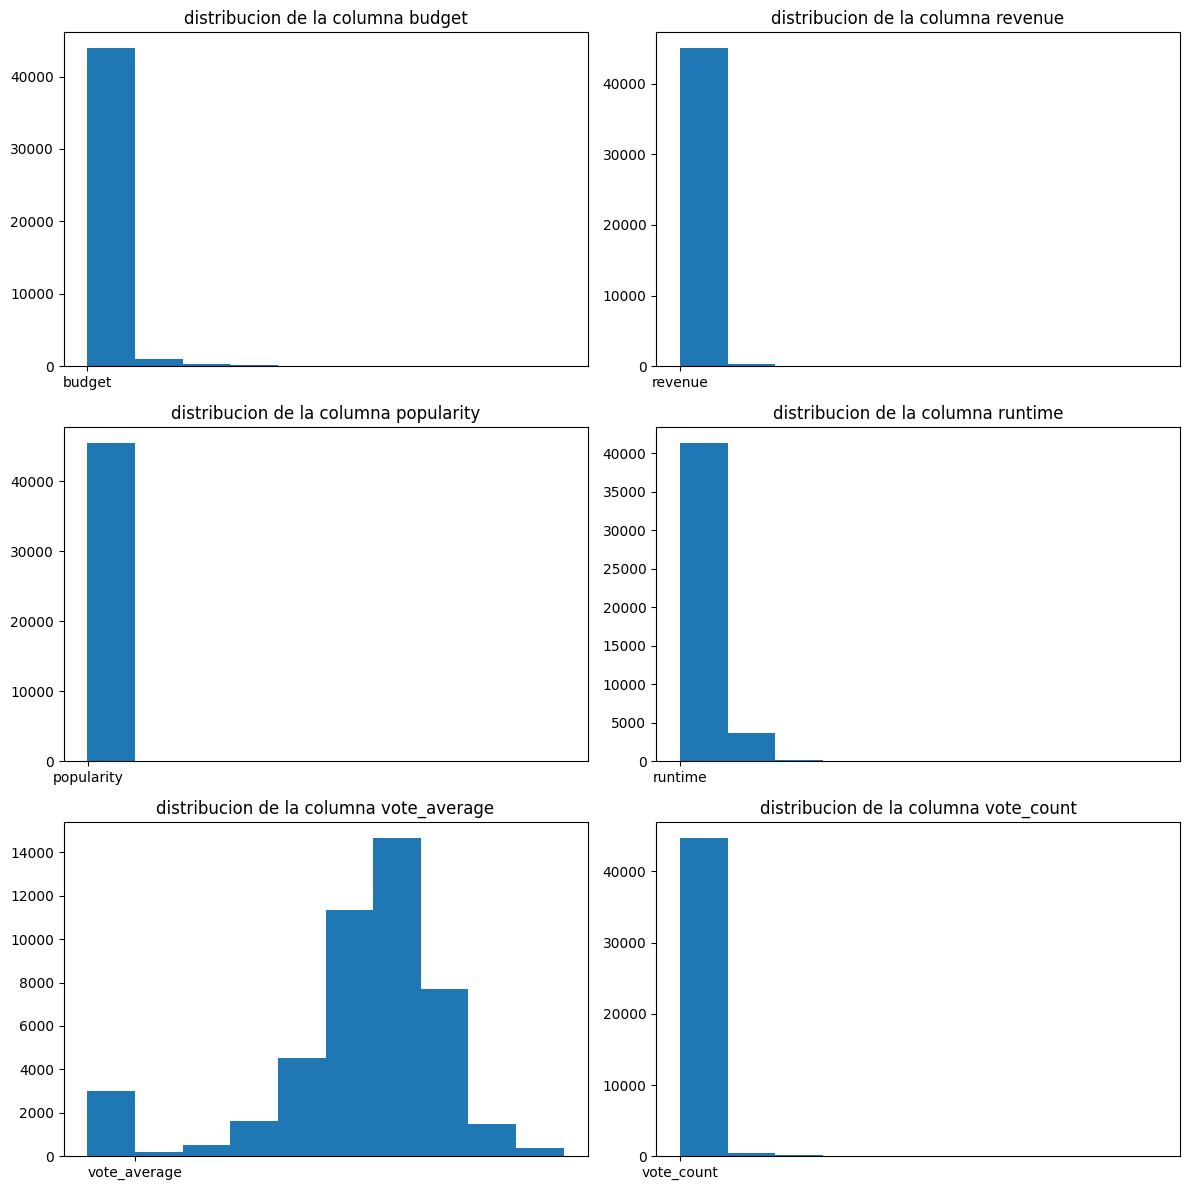

In [197]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Define the columns to plot
columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']

# La i va a ser el indice de cada subplot y ax representa la posicion donde se va a graficar este
for i, ax in enumerate(axs.flat):
    column = columns[i]
    ax.hist([movies[column]])
    ax.set_title(f"distribucion de la columna {column}")
    ax.set_xticks([1])
    ax.set_xticklabels([column])

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()

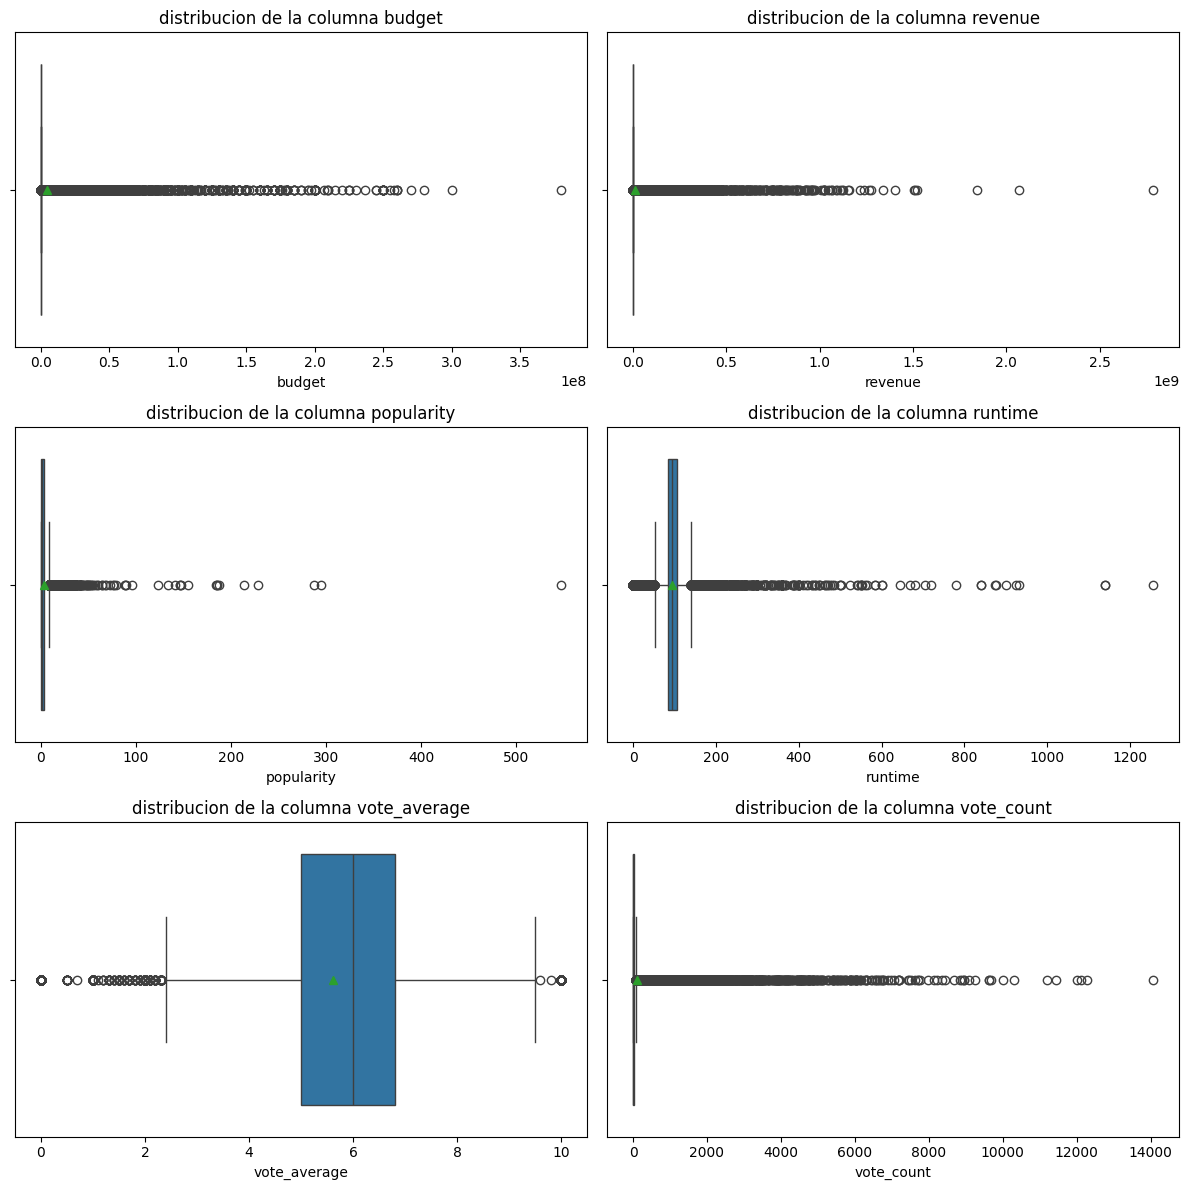

In [198]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']

for i, ax in enumerate(axs.flat):
    column = columns[i]
    sns.boxplot(x=movies[column], showmeans=True, ax=ax)
    ax.set_title(f"distribucion de la columna {column}")

fig.tight_layout()

plt.show()

viendo esto me doy la idea que la unica que podria llegar a ser util en la similitud del coseno es vote_average.
Por otro lado, en los histogramas de algunas columnas no se alcanzan a ver los maximos, dandome a entender que no esta muy bien distribuida la data, a eso hay que sumarle que en la representacion grafica de cajas y bigotes tambien tenemos la anomalia de ver que en muchas ni siquiera se forma el cuerpo de la caja. Como diria Arnaldo "Hasta la vista columnas"

###
###
###

*Buscando en la web, encontre que varias de las 'peliculas' que sobresalian de los 240 min(4horas), son peliculas experimentales, y otras cuantas son documentales o series, por lo que, para mejorar el analisis, voy a filtrar solo por las que tengan menos de 240 minutos*

In [220]:
movies = movies[movies['runtime']<240]

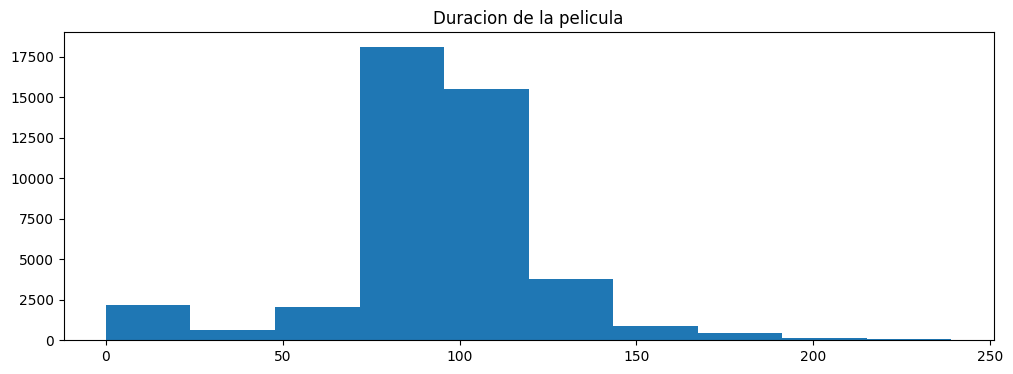

In [231]:
plt.figure(figsize=(12,4))
plt.hist(movies['runtime'])
plt.title("Duracion de la pelicula")
plt.show()

---

In [200]:
movies = movies.drop(['popularity','budget','revenue','vote_count'],axis=1)
movies.head()

,id,title,name_genres,runtime,vote_average,status,overview,release_year
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,7.7,Released,"Led by Woody, Andy's toys live happily in his ...",1995.0
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,6.9,Released,When siblings Judy and Peter discover an encha...,1995.0
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,6.5,Released,A family wedding reignites the ancient feud be...,1995.0
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,6.1,Released,"Cheated on, mistreated and stepped on, the wom...",1995.0
4,11862.0,Father of the Bride Part II,[Comedy],106.0,5.7,Released,Just when George Banks has recovered from his ...,1995.0


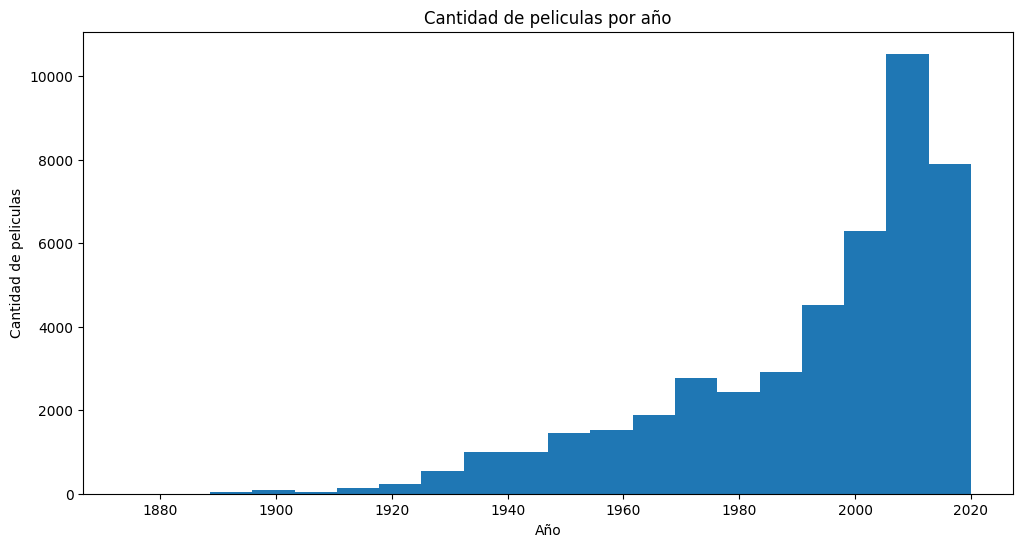

In [201]:
plt.figure(figsize=(12, 6))
plt.hist(movies['release_year'], bins=20)
plt.xlabel('Año')
plt.ylabel('Cantidad de peliculas')
plt.title('Cantidad de peliculas por año')
plt.show()

Bueno, claramente la industria ha tenido un crecimiento desde sus primeros años, y cada epoca ha tenido un boom o formas de narrar las historias por lo que podria considerar al año como un dato relevante para el entrenamiento

###
###


---

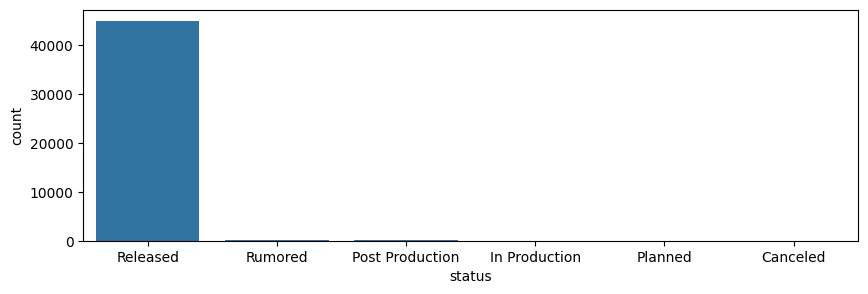

In [202]:
plt.figure(figsize=(10,3))
barras = sns.countplot(data=movies, x='status')
plt.show()

En status hay un par de barritas que tiran como que hubieran peliculas que no fueron estrenadas, voy a separarlas para no estar analizando peliculas que ni siquieran salieron o que solamente se hayan rumoreado

In [203]:
df_filtrado = movies.copy()
df_filtrado = df_filtrado[df_filtrado['status']!='Released']
df_filtrado.head()

,id,title,name_genres,runtime,vote_average,status,overview,release_year
189,56088.0,The Show,[Documentary],93.0,5.3,None,A documentary about the culture of hip-hop. Th...,1995.0
682,48260.0,Butterfly Kiss,"[Crime, Drama, Romance, Thriller]",88.0,7.4,Rumored,Eunice is walking along the highways of northe...,1995.0
767,52059.0,The Gate of Heavenly Peace,[Documentary],180.0,6.7,None,The Gate of Heavenly Peace is a feature-length...,1995.0
775,44495.0,A Very Natural Thing,[Drama],80.0,6.3,Rumored,"When David, an ex-monk still in his twenties m...",1974.0
1032,38191.0,The Sunchaser,[Drama],122.0,6.1,Rumored,A young half-Navajo convict (Jon Seda) dying o...,1996.0


De 3 titulos investigados rapidamente, encontre que: 
- King's road, fue una pelicula estrenada pero diferia en los datos del año  
- Butterfly Kiss tiene dos versiones hechas en 2 paises distintos  
- The Surrender of Tournavos fue una 'corto-mudo' lanzado en 1897
  
voy a hacer la opcion mas facil para evitarme problemas, y filtrar solo por las peliculas que estan etiquetadas como 'Released', el resto, ~~Rumored, Canceled, Post Production, In Production y Planned~~, las voy a eliminar

In [204]:
movies = movies[movies['status']=='Released']


###
###


---

Ahora quiero ver si overview es un dato util o no

In [205]:
# voy a mirar que tipos de overviews se repiten
movies.overview.value_counts()

overview
No overview found.                                                                                                                                                                                                                                                                                                                                                                                                                                           133
No Overview                                                                                                                                                                                                                                                                                                                                                                                                                                                    7
                                                                                             

In [206]:
# filtro las que se repiten como "No overview..."
resumen = movies[(movies['overview']!='No overview found') & (movies['overview']!='No overview')]
resumen

,id,title,name_genres,runtime,vote_average,status,overview,release_year
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,7.7,Released,"Led by Woody, Andy's toys live happily in his ...",1995.0
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,6.9,Released,When siblings Judy and Peter discover an encha...,1995.0
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,6.5,Released,A family wedding reignites the ancient feud be...,1995.0
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,6.1,Released,"Cheated on, mistreated and stepped on, the wom...",1995.0
4,11862.0,Father of the Bride Part II,[Comedy],106.0,5.7,Released,Just when George Banks has recovered from his ...,1995.0
...,...,...,...,...,...,...,...,...
45461,439050.0,Subdue,"[Drama, Family]",90.0,4.0,Released,Rising and falling between a man and woman.,NaN
45462,111109.0,Century of Birthing,[Drama],360.0,9.0,Released,An artist struggles to finish his work while a...,2011.0
45463,67758.0,Betrayal,"[Action, Drama, Thriller]",90.0,3.8,Released,"When one of her hits goes wrong, a professiona...",2003.0
45464,227506.0,Satan Triumphant,[],87.0,0.0,Released,"In a small town live two brothers, one a minis...",1917.0


In [207]:
nltk.download('stopwords')
# guardamos en una variable los stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/mjb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [208]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [209]:
# creo la funcion para eliminar las palabras que se encuentren dentro de las stopwords
def remove_stopwords(text):
    # la siguiente linea se hace para evitar este error en caso de que durante la iteracion se encuentre con un objeto nulo
    # AttributeError: 'NoneType' object has no attribute 'split'
    if text is None or text =='':
        return ''
    #por cada 'PALABRA' dentro del texto 'TEXT' (recortada por cada salto de linea), se anidara en la lista
    # tokens siempre que esta 'PALABRA' no coincida con ninguna palabra dentro de la variable STOP_WORDS
    tokens = [word for word in text.split() if word.lower() not in stop_words]

    return ' '.join(tokens)

In [210]:
resumen['overview'] = resumen['overview'].apply(remove_stopwords)

/tmp/ipykernel_76406/4051368871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resumen['overview'] = resumen['overview'].apply(remove_stopwords)


In [211]:
resumen

,id,title,name_genres,runtime,vote_average,status,overview,release_year
0,862.0,Toy Story,"[Animation, Comedy, Family]",81.0,7.7,Released,"Led Woody, Andy's toys live happily room Andy'...",1995.0
1,8844.0,Jumanji,"[Adventure, Fantasy, Family]",104.0,6.9,Released,siblings Judy Peter discover enchanted board g...,1995.0
2,15602.0,Grumpier Old Men,"[Romance, Comedy]",101.0,6.5,Released,family wedding reignites ancient feud next-doo...,1995.0
3,31357.0,Waiting to Exhale,"[Comedy, Drama, Romance]",127.0,6.1,Released,"Cheated on, mistreated stepped on, women holdi...",1995.0
4,11862.0,Father of the Bride Part II,[Comedy],106.0,5.7,Released,"George Banks recovered daughter's wedding, rec...",1995.0
...,...,...,...,...,...,...,...,...
45461,439050.0,Subdue,"[Drama, Family]",90.0,4.0,Released,Rising falling man woman.,NaN
45462,111109.0,Century of Birthing,[Drama],360.0,9.0,Released,artist struggles finish work storyline cult pl...,2011.0
45463,67758.0,Betrayal,"[Action, Drama, Thriller]",90.0,3.8,Released,"one hits goes wrong, professional assassin end...",2003.0
45464,227506.0,Satan Triumphant,[],87.0,0.0,Released,"small town live two brothers, one minister one...",1917.0


In [212]:
# ahora vamos a unir todas las palabras de la columna OVERVIEW en una sola variable str llamada texto
texto = ' '.join(resumen['overview'])

- finalmente la gran nube de palabras!

In [213]:
# por lo que estuve leyendo wordcloud genera imagenes de baja calidad para acelerar 
#  el procesamiento de grandes cantidades de texto, como esto es aun relativamente
#   una cantidad baja de texto, vamos a aumentar la calidad con el argumento scale=5
word_cloud = WordCloud(scale=5).generate(texto)

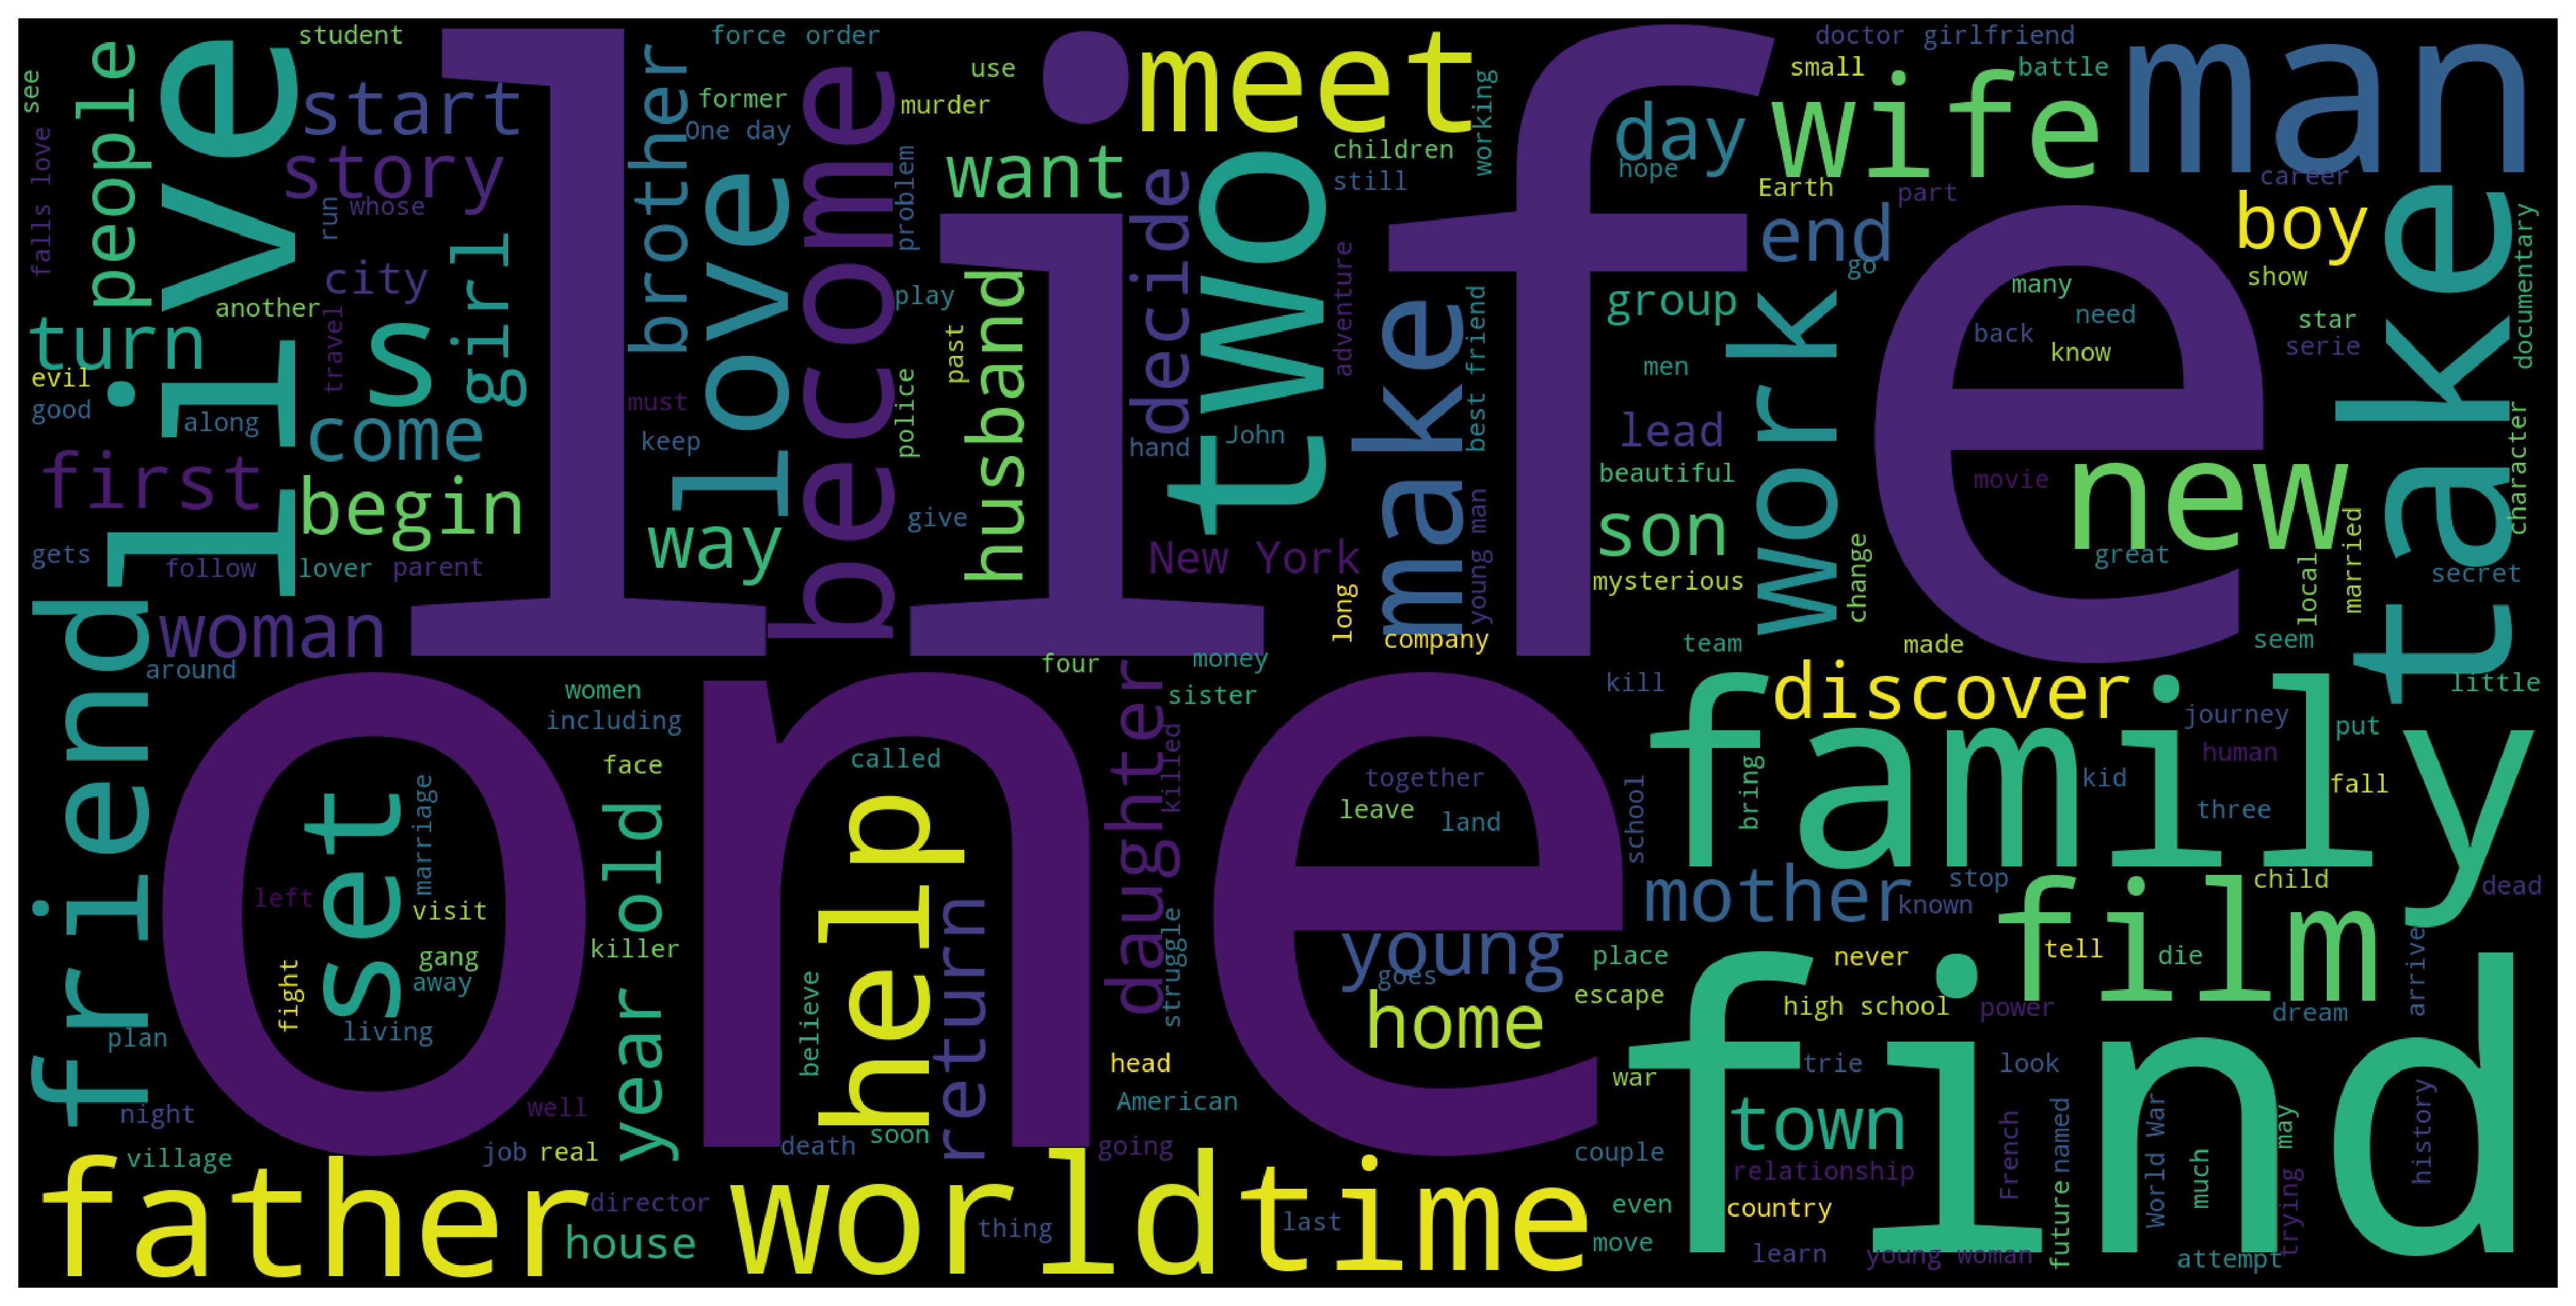

In [214]:
plt.figure(figsize=(18,9), dpi=300)
plt.imshow(word_cloud, interpolation='nearest')
plt.axis('off')
plt.show()

###
###


*life, one, two, family, take, find, live y otras mas siguen siendo palabras muy genericas aun, por lo que no voy a incluir la columna de overview como para definir alguna relacion con las peliculas* ....

###
###


---

limpiamos algunas filas con datos nulos

In [215]:
movies.dropna(inplace=True)

In [216]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44021 entries, 0 to 45465
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            44021 non-null  float64
 1   title         44021 non-null  object 
 2   name_genres   44021 non-null  object 
 3   runtime       44021 non-null  float64
 4   vote_average  44021 non-null  float64
 5   status        44021 non-null  object 
 6   overview      44021 non-null  object 
 7   release_year  44021 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB


###
###
###


---

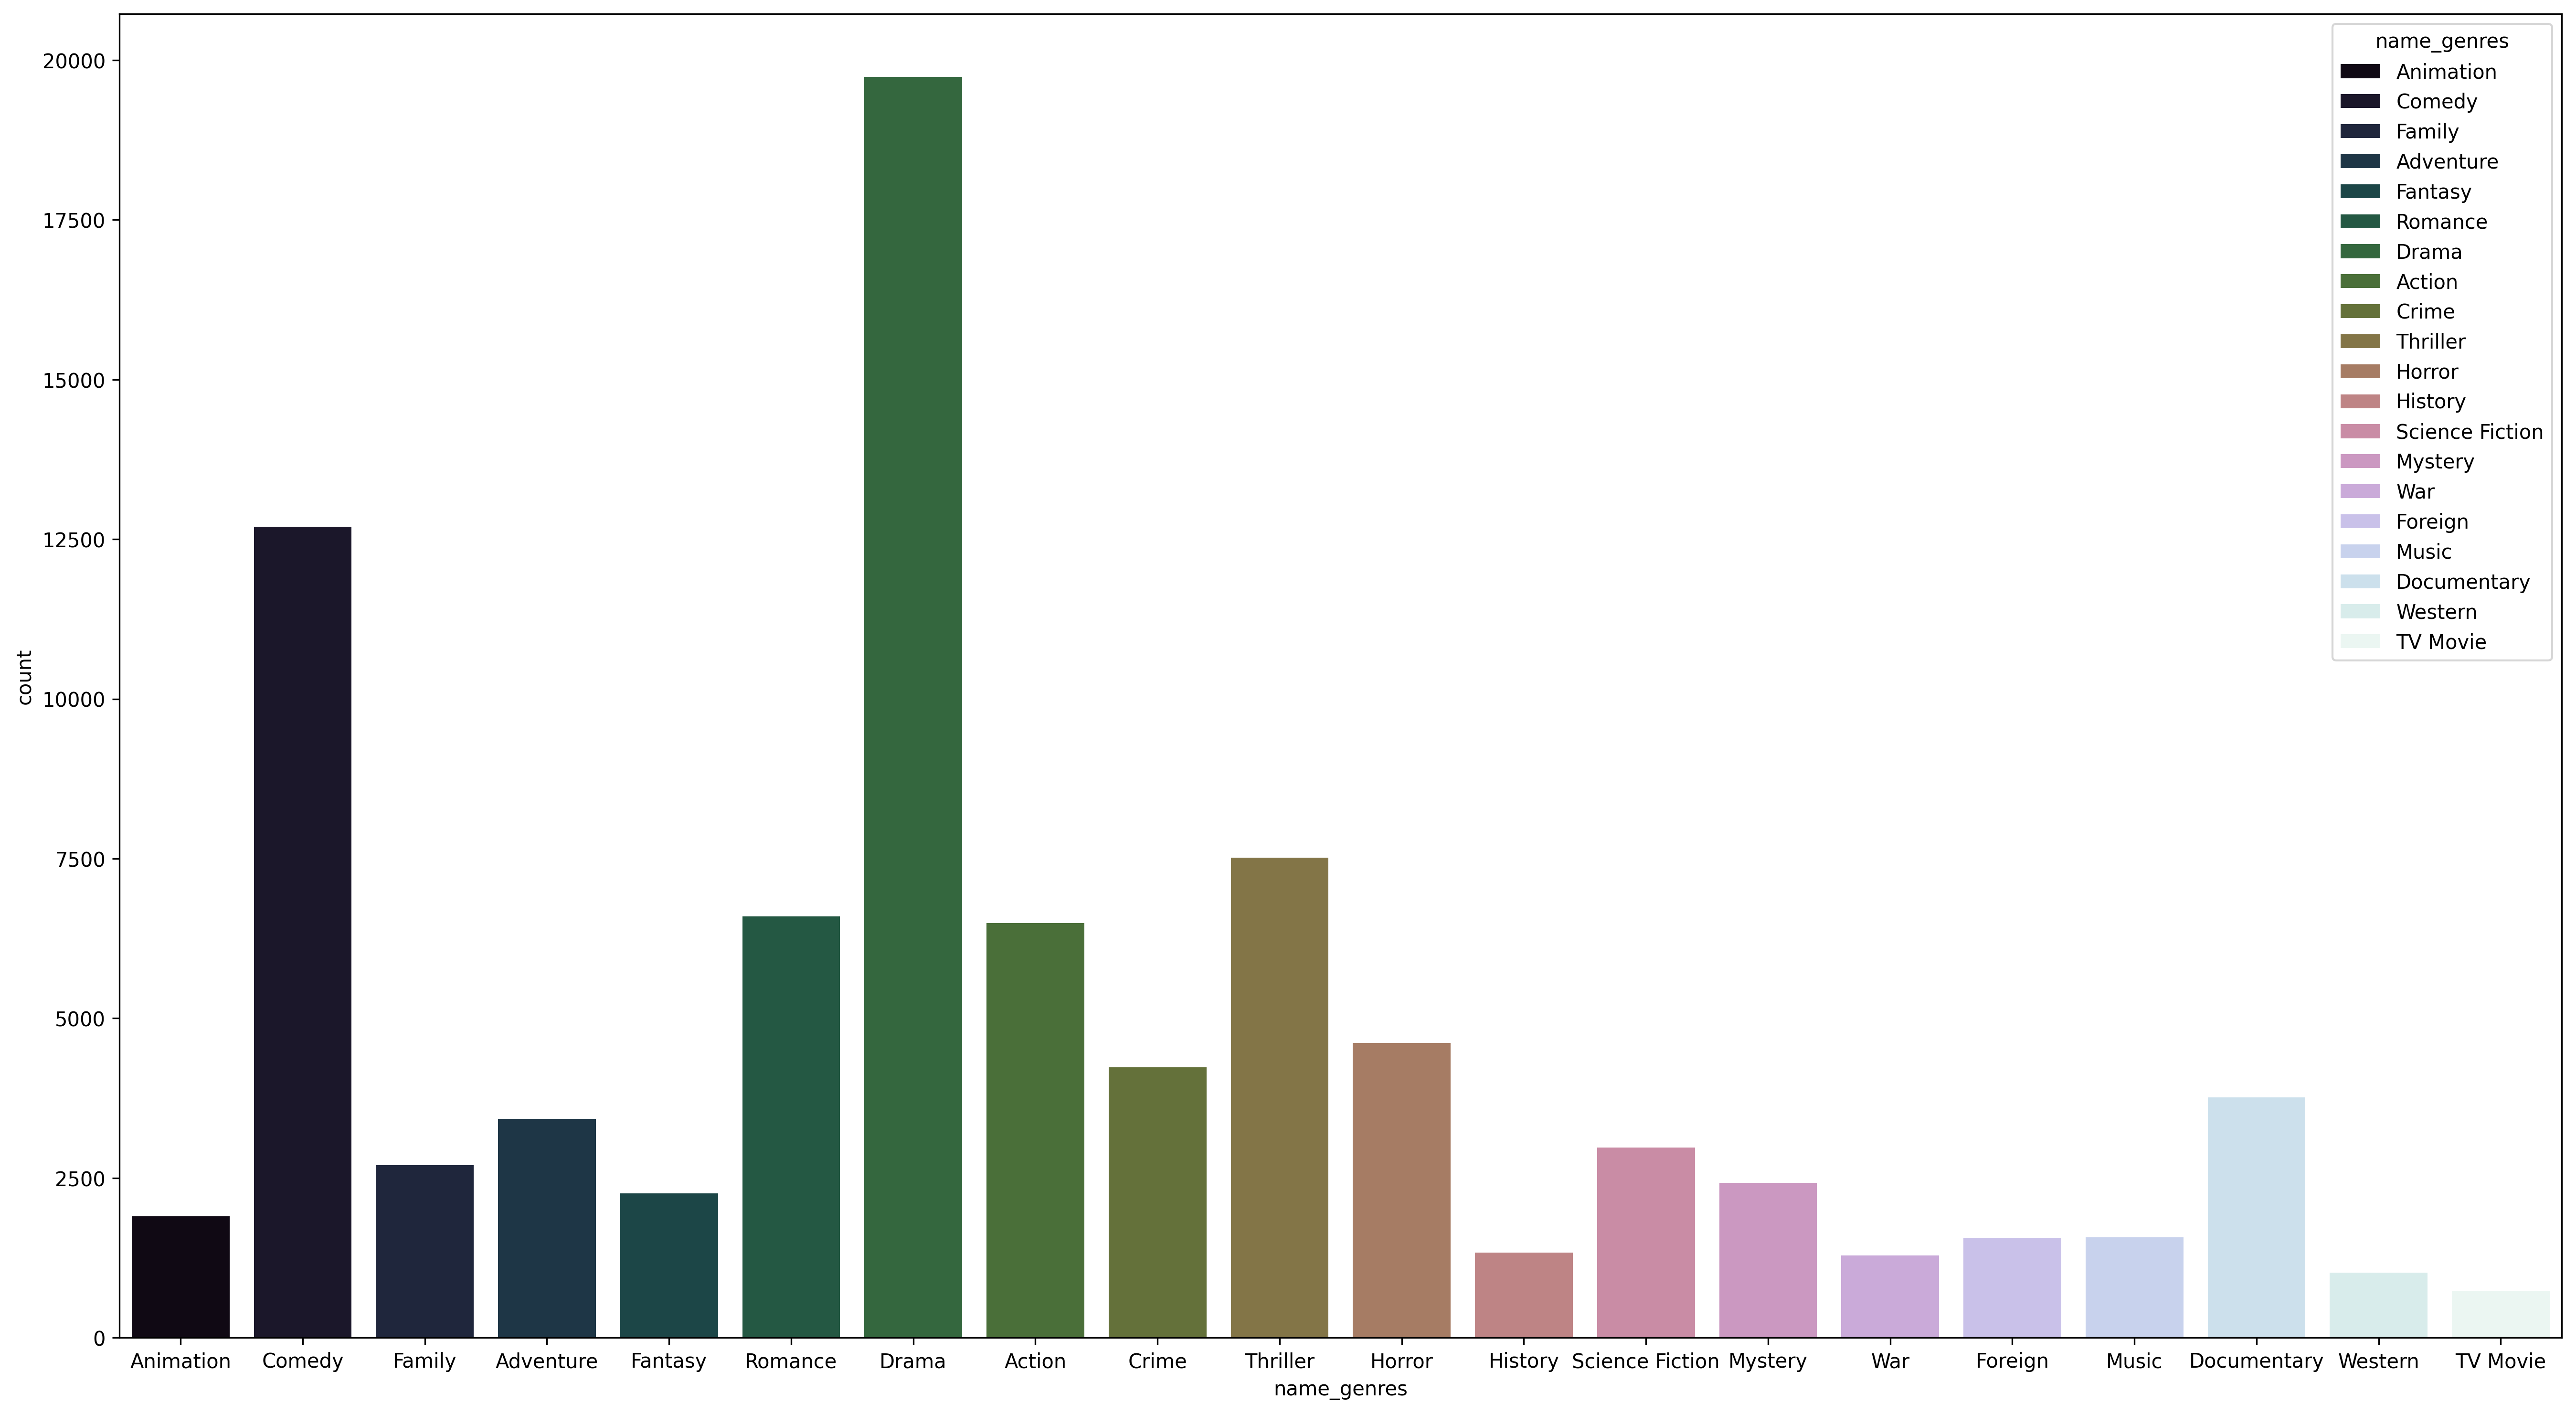

In [240]:
movies_desanidados = movies.explode('name_genres')
movies_desanidados = movies_desanidados.reset_index(drop=True)

plt.figure(figsize=(22,12),dpi=300)
sns.countplot(data=movies_desanidados, x='name_genres', hue='name_genres',palette='cubehelix')
plt.show()

Con esto ya tengo una idea cuales son los generos dominantes en el cine